# Module 5

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import skimage as ski #for different image analysis algorithms
import skimage.filters
import image_analysis as anl
import seaborn as sns; sns.set_style('white'); sns.set_context('notebook')

In [2]:
figfile = "Processed/"

## 5.1 - Least Squares Fit

If the form of the noise is Gaussian, a least-squares gaussian fit should work.

In [3]:
scale_true = 5 #in nm/pixel
lam = 509 #in nm
ccd_scale = 100 #in nm/pixel
SNr = 10
bkg = 10

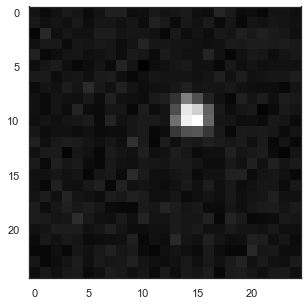

In [4]:
pic = np.zeros([500,500]); pic[200,300] = 1
simulated = anl.simulator(pic, scale_true, lam, ccd_scale, SNr, bkg)
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray');

In [5]:
A,x0,y0,sigma,offset = anl.gauss2_fit_LS(simulated)
print(A, x0, y0, sigma, offset)

125.52879479404535 14.484779049733692 9.538183359080591 -0.9712497482469811 10.100766786262158


Note that the molecule centre is less accurate.

In [6]:
x = np.arange(0, np.shape(simulated)[1]-0.5, 0.5e-1)
y = np.arange(0, np.shape(simulated)[0]-0.5, 0.5e-1)
X, Y = np.meshgrid(x, y)
reconstructed = anl.gaussian2d_symm((X,Y),A,x0,y0,sigma,offset,ravel=False)

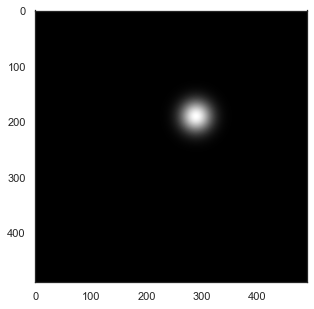

In [7]:
plt.figure(figsize = (5,5))
plt.imshow(reconstructed, cmap = 'gray')
plt.savefig(figfile+"LS_gaussfit_reconstructed_offcentred.png",dpi = 300);

## 5.3 Bacteria Localization

1\. Create a bacterium.

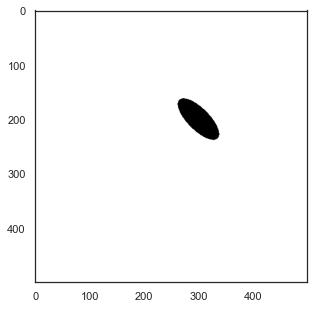

In [8]:
pic = np.zeros([500,500])
rr, cc = ski.draw.ellipse(200, 300, 50, 20, rotation = np.pi/4)
pic[rr, cc] = 255

plt.figure(figsize = (5,5))
plt.imshow(pic, cmap = 'gray_r');
plt.savefig(figfile+"idealized_bacterium.png",dpi = 300)

2\. Simulate the ideal bacterium

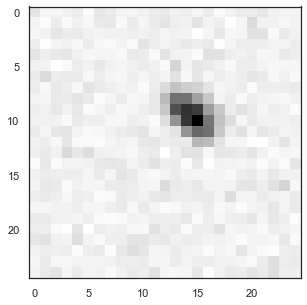

In [9]:
simulated = anl.simulator(pic, scale_true, lam, ccd_scale, SNr, bkg)
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray_r')
plt.savefig(figfile+"simulated_bacterium.png",dpi = 300)

3\. Fit asymmetric gaussian to image. 

In [10]:
A,x0,y0,sigma,offset,theta = anl.gauss2_fit_MLE(simulated, symm = False)
print(A, x0, y0, sigma, offset, theta)

Sucess: True
114.31187270844231 14.50538093548129 9.518970593007202 [1.66176516 1.02882327] 10.341872766679888 -0.7624633587224198


4\. Plot asymmetric gaussian.

In [11]:
x = np.arange(0, np.shape(simulated)[1]-0.5, 0.1)
y = np.arange(0, np.shape(simulated)[0]-0.5, 0.1)
X, Y = np.meshgrid(x, y)
reconstructed = anl.gaussian2d_asymm((X,Y),A,x0,y0,sigma[0],sigma[1],offset,theta,ravel=False)

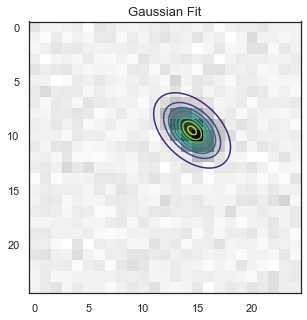

In [12]:
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray_r')
plt.contour(X,Y,reconstructed, cmap = 'viridis')
plt.title('Gaussian Fit',size =13)
plt.savefig(figfile+"simulated_bacterium_localized_gaussfit.png",dpi = 300)

5\. Verify _true_ centre value.

In [13]:
y_ccd_point, x_ccd_point = anl.transform_ccd_coords(pic,scale_true,ccd_scale,200,300)
print('Xtrue:',np.round(x_ccd_point,decimals = 3), '| Ytrue:',np.round(y_ccd_point,decimals = 3))

Xtrue: 14.525 | Ytrue: 9.525


## Multiple Bacteria

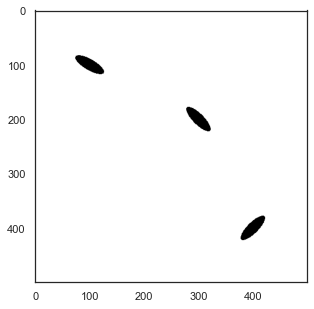

In [14]:
pic = np.zeros([500,500])
rr0, cc0 = ski.draw.ellipse(200, 300, 30, 10, rotation = np.pi/4)
rr1, cc1 = ski.draw.ellipse(400, 400, 30, 10, rotation = 3*np.pi/4)
rr2, cc2 = ski.draw.ellipse(100, 100, 30, 10, rotation = 7*np.pi/3)
pic[rr0, cc0] = 255; pic[rr1, cc1] = 255; pic[rr2, cc2] = 255

plt.figure(figsize = (5,5))
plt.imshow(pic, cmap = 'gray_r');
plt.savefig(figfile+"multiple_idealized_bacteria.png",dpi = 300)

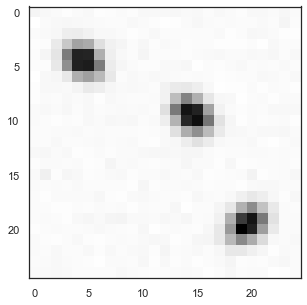

In [15]:
simulated = anl.simulator(pic, scale_true, lam, ccd_scale, 20, 10)
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray_r')
plt.savefig(figfile+"multiple_simulated_bacteria.png",dpi = 300)

In [16]:
#Define number of points
N = 3

In [17]:
x = np.arange(0, np.shape(simulated)[1]-0.5, 0.1)
y = np.arange(0, np.shape(simulated)[0]-0.5, 0.1)
X, Y = np.meshgrid(x, y)

In [18]:
A = np.zeros(N); x0 = A.copy(); y0 = A.copy(); sigma = np.zeros([N,2]); offset = A.copy(); theta = A.copy()
reconstructed = np.zeros([np.shape(X)[1],np.shape(Y)[1],N])
fac = 2
for i,m in enumerate(np.arange(0,fac*N-1,fac)):
    A[i],x0[i],y0[i],sigma[i],offset[i],theta[i] = anl.gauss2_fit_MLE(simulated, symm = False, n=m, det_lim = 0.865)
plt.show()

Sucess: True
Sucess: True
Sucess: True


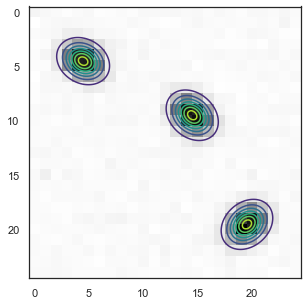

In [19]:
plt.figure(figsize = (5,5))
plt.imshow(simulated, cmap = 'gray_r');
reconstructed = np.zeros([np.shape(X)[0], np.shape(X)[0], N])
for i in range(N):
    reconstructed = anl.gaussian2d_asymm((X,Y), A[i], x0[i], y0[i], sigma[i][0], 
                                         sigma[i][1], offset[i], theta[i], ravel = False)
    plt.contour(X,Y,reconstructed, cmap = 'viridis')
plt.savefig(figfile+"multiple_simulated_bacteria_localized.png",dpi = 300)

Verifying Accuracy

In [20]:
for i in range(N):
    print(np.round([y0[i], x0[i]],decimals = 3))

[4.523 4.483]
[ 9.502 14.519]
[19.542 19.552]


In [21]:
print(np.round(anl.transform_ccd_coords(pic,scale_true,ccd_scale,200,300),decimals = 3))
print(np.round(anl.transform_ccd_coords(pic,scale_true,ccd_scale,400,400),decimals = 3))
print(np.round(anl.transform_ccd_coords(pic,scale_true,ccd_scale,100,100),decimals = 3))

[ 9.525 14.525]
[19.525 19.525]
[4.525 4.525]


This is pretty good! *Note that this works only with low background noise and cleanly seperated ellipsoids.*